In [1]:
import json
import networkx as nx
import requests
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from community import community_louvain

### 1. get the data from json file (node & edges) and bulid the basic network


In [2]:

nodes_edges_json_file = './data/nodes_egdes.json'
with open(nodes_edges_json_file,'r') as f:
    node_edges = json.load(f)

# bulid the network from data 
G = nx.DiGraph()

# add nodes    
G.add_nodes_from(node_edges.keys())

# add links
for each in node_edges:
    for link in node_edges[each]:
        G.add_edge(each,link)

print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

number of nodes in network:4264
number of links in network:113936


### 2. define the attributes we want
#### (a) house  
Follow this link, get the attribute of the nodes. Link:
https://harrypotter.fandom.com/wiki/Category:Individuals_by_Hogwarts_house  
Notice that there will be lots of nodes without the house information(not in the list above)
#### (b) muggle or wizard
List for muggles: https://harrypotter.fandom.com/wiki/Category:Muggles  
Also the blood information: https://harrypotter.fandom.com/wiki/Category:Individuals_by_parentage(might be explored if we have spare time)  
*it is interesting that Harry Potter is half-blood.*
#### (c) good or evil (and maybe netural)
No specific one but might get an insight from: https://harrypotter.fandom.com/wiki/Category:Individuals_by_allegiance


### 3. get the attributes with character name by the link and add the attribues to the network
#### (a) house

In [3]:
baseurl = "https://harrypotter.fandom.com/api/v1/Articles/List?"
expand = "expand=1"
namespaces = "namespaces=0"
limit = "limit={}".format(1000)



house_cate_url = 'https://harrypotter.fandom.com/api/v1/Articles/List?expand=1&category=Individuals_by_Hogwarts_house&namespaces=0&limit=100'
r = requests.get(house_cate_url)
response = r.json()

a = 0
house_list = {}
for item in response['items']:
    a += 1
    print("{}\t{}\t({})".format(str(a),item['title'].encode(encoding='utf-8'),item['id']))
    house_name = str(item['title'].encode(encoding='utf-8'))[2:-1]
#     sub_cat.append(title[2:-1])
    house_list[house_name] = []
    
    # for each house 
    category = "category={}".format(house_name)
    query = "{}{}&{}&{}&{}".format(baseurl, expand, category, namespaces, limit)
    r = requests.get(query)
    response = r.json()
    

    for item in response['items']:
        cha_name = str(item['title'].encode(encoding='utf-8'))[2:-1]
        house_list[house_name].append(cha_name)


1	b'Gryffindors'	(76)
2	b'Hufflepuffs'	(329)
3	b'Ravenclaws'	(75)
4	b'Slytherins'	(292)
5	b'Unknown House'	(209171)


In [4]:
# basic statstic of each house
for each_house in house_list:
    print('{} has {} characters'.format(each_house,len(house_list[each_house])))

Gryffindors has 262 characters
Hufflepuffs has 169 characters
Ravenclaws has 165 characters
Slytherins has 223 characters
Unknown House has 164 characters


In [5]:
# get the attribute dist for adding the attibute information into the Graph
house_attr = {}
Hogwarts_cha_list = [] # for collecting characters who once went to Hogwarts
for node_name in G.nodes():
    name_clean = node_name.replace('_',' ')
    house_type = 'Unknown'
    if name_clean in house_list['Gryffindors']:
        house_type = 'Gryffindors'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Hufflepuffs']:
        house_type = 'Hufflepuffs'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Ravenclaws']:
        house_type = 'Ravenclaws'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Slytherins']:
        house_type = 'Slytherins'
        Hogwarts_cha_list.append(node_name)
    elif name_clean in house_list['Unknown House']:  
        house_type = 'Unknown'
        Hogwarts_cha_list.append(node_name)
    else:
        house_type = 'Unknown'
    
    house_attr[node_name] = house_type
    
# add the attribute to the network
nx.set_node_attributes(G,house_attr,'house_type')

### 4. get the sub-network of Hogwarts

Notice that the rest of characters are not very important if we wanna explore the Hogwarts Houses.

In [6]:
# subgraph
G_Hogwarts = G.subgraph(Hogwarts_cha_list)
# basic stat
print('number of nodes in Hogwarts network:{}'.format(len(G_Hogwarts.nodes())))
print('number of links in Hogwarts network:{}'.format(len(G_Hogwarts.edges())))

number of nodes in Hogwarts network:977
number of links in Hogwarts network:29889


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:23<00:00, 27.91it/s]


BarnesHut Approximation  took  17.96  seconds
Repulsion forces  took  117.38  seconds
Gravitational forces  took  0.67  seconds
Attraction forces  took  1.58  seconds
AdjustSpeedAndApplyForces step  took  2.36  seconds


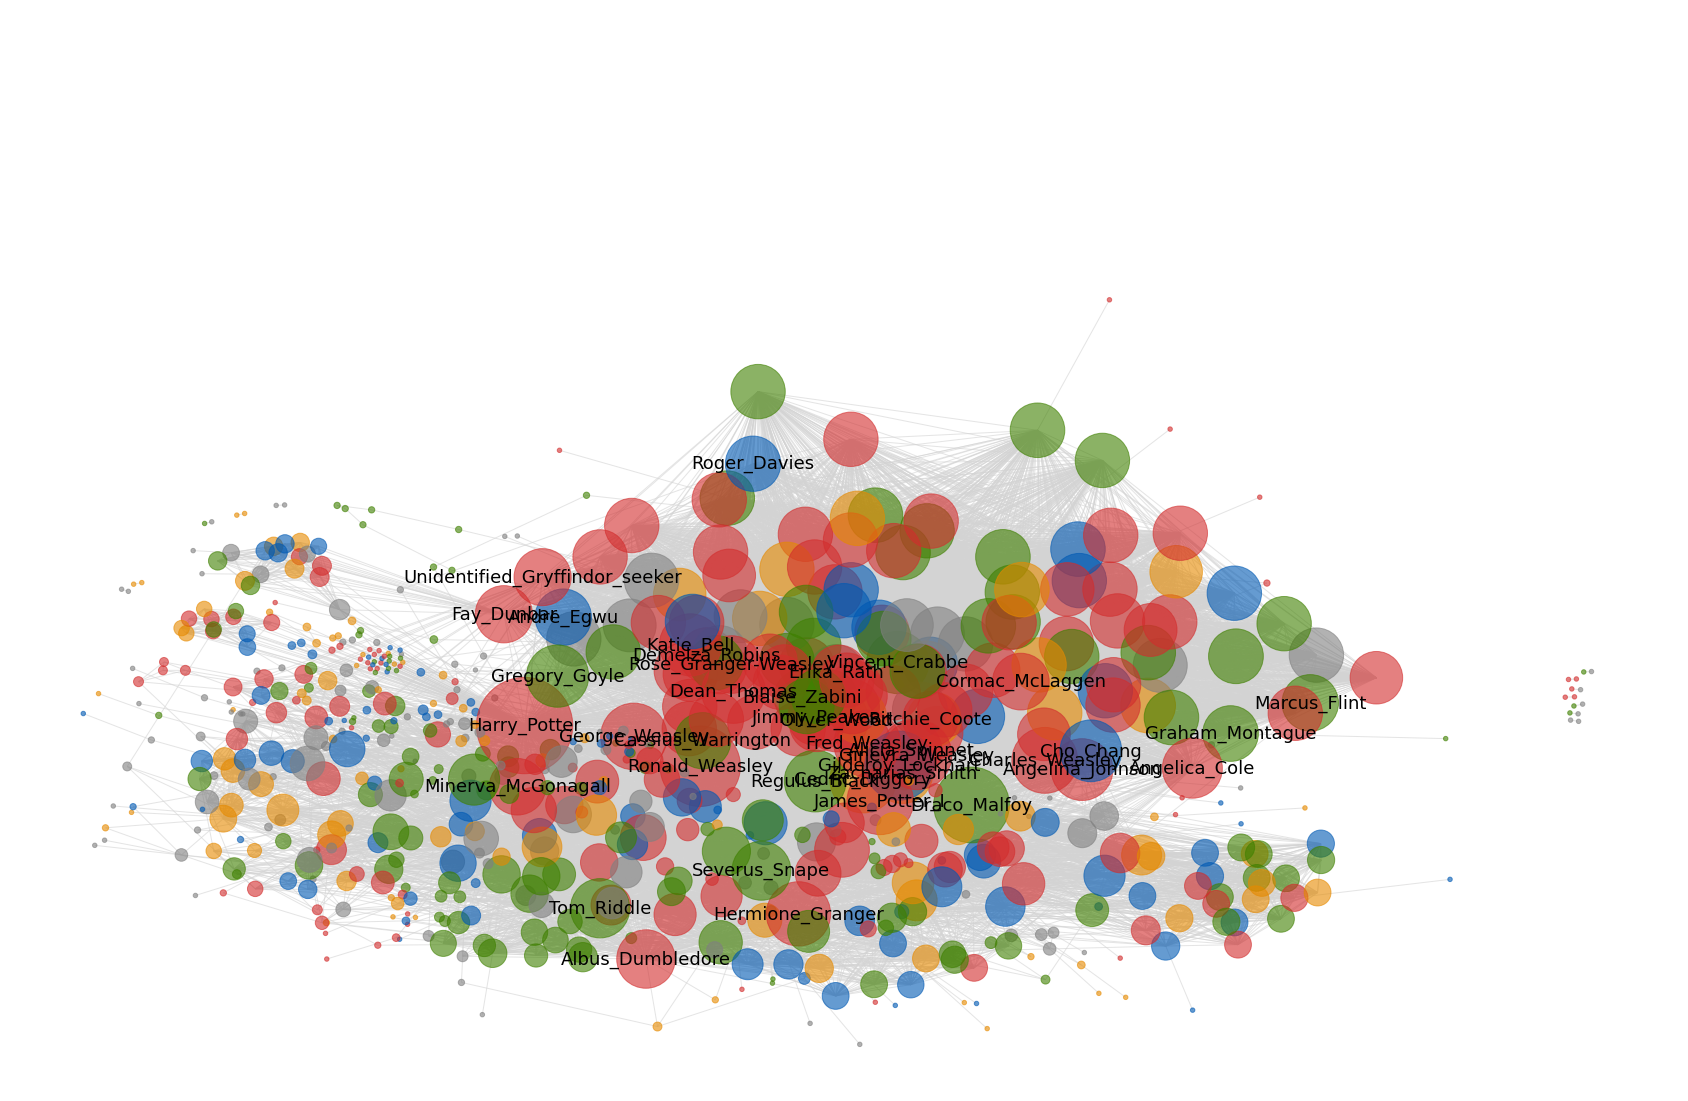

In [30]:
# visualization

G_Hogwarts_undirect = G_Hogwarts.to_undirected()

# get the dict of degree in G undirected 
d = dict(G_Hogwarts_undirect.degree)

# get the top 20 degree character
d_sorted = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

top_20_cha = list(d_sorted.keys())[0:40]

# represent for Gryffindors, Hufflepuffs, Ravenclaws and Slytherins respectively (and also unknow ones)
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#808080']

# color map for nodes
color_map_nodes = []
for node in list(G_Hogwarts_undirect.nodes()):
    if nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Gryffindors':
        color_map_nodes.append(colors[0])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Hufflepuffs':
        color_map_nodes.append(colors[1])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Ravenclaws':
        color_map_nodes.append(colors[2])
    elif nx.get_node_attributes(G_Hogwarts_undirect,'house_type')[node] == 'Slytherins':
        color_map_nodes.append(colors[3])
    else:
        color_map_nodes.append(colors[4])
    
plt.figure(figsize=(30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.001, #More makes a more sparse graph
                        strongGravityMode=False,
                        gravity=5.0, # increse this, the nodes will be attracted to the center more

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_Hogwarts_undirect, pos=None, iterations=4000)
nx.draw_networkx(G_Hogwarts_undirect, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_undirect,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()


### 5. community detection

In [31]:
partition = community_louvain.best_partition(G_Hogwarts_undirect,random_state=0)

In [32]:
par_class = set(partition.values())
par_class_dict = {}
for v in partition.values():
    str_v = str(v)
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [33]:
par_sorted = sorted(par_class_dict.items(),key= lambda item:item[1],reverse = True)
print(par_sorted[:10])
selected_par = list(dict(par_sorted).keys())[:5]
print(selected_par)

[('0', 445), ('4', 150), ('21', 45), ('37', 19), ('19', 12), ('3', 6), ('28', 3), ('43', 3), ('10', 2), ('49', 2)]
['0', '4', '21', '37', '19']


In [34]:
community = {}
for par in selected_par:
    com_name = 'com_'+str(par)
    community[com_name] = []
community['other'] = []

for node in G_Hogwarts_undirect.nodes():
    if str(partition[node]) in selected_par:
        com_name = 'com_'+str(partition[node])
        community[com_name].append(node)
    else:
        community['other'].append(node)

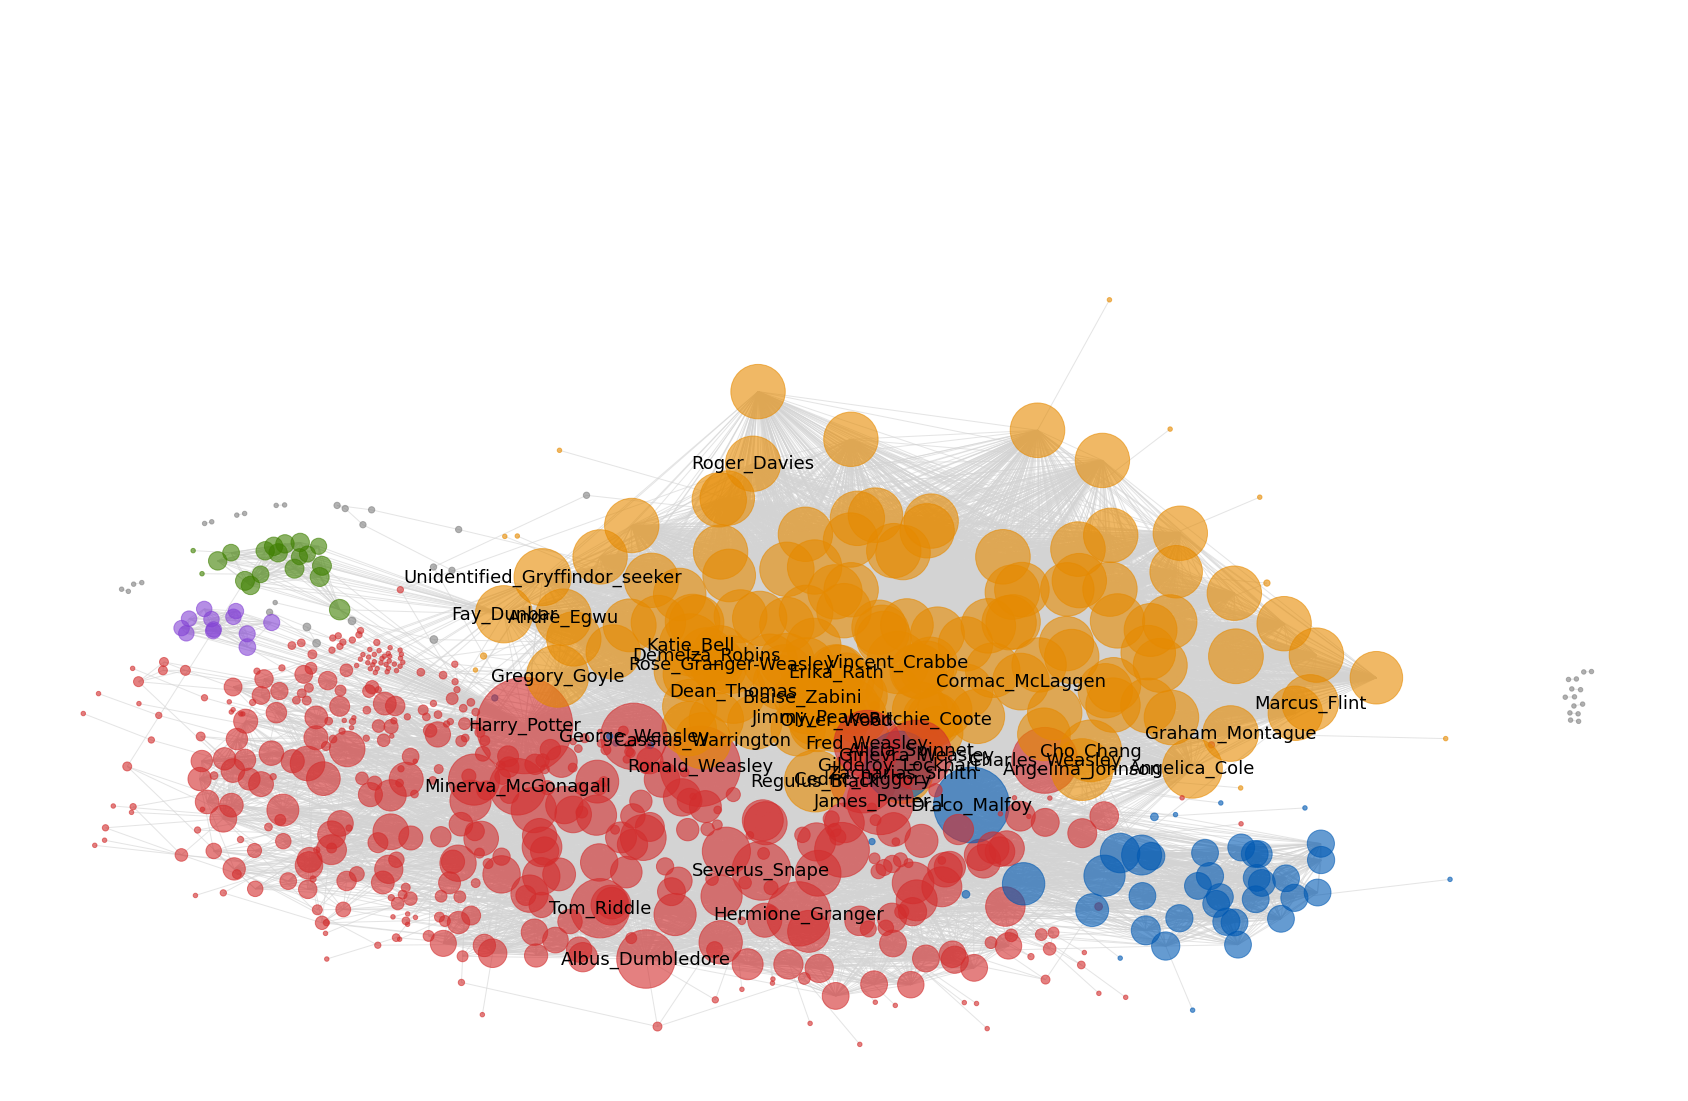

In [35]:
colors = ['#d22d2d','#e68a00','#0059b3','#3f8000','#8443D5','#808080'] # 5 main community + other

# create a dict for each community
color_dict = {}
for i,par in enumerate(selected_par):
    color_dict[par] = colors[i]
color_dict['other'] = colors[-1]

# color map for nodes
color_map_nodes_2 = []
for node in list(G_Hogwarts_undirect.nodes()):
    if str(partition[node]) in selected_par:
        color = color_dict[str(partition[node])]
    else:
        color = color_dict['other'] 
    color_map_nodes_2.append(color)

plt.figure(figsize=(30,20))
nx.draw_networkx(G_Hogwarts_undirect, positions,nodelist=d.keys(), node_size=[v * 20 for v in d.values()], node_color = color_map_nodes_2,alpha = 0.6,\
                    edge_color ='lightgrey',with_labels=False)
labels = {}
for node in top_20_cha:
    labels[node] = node
nx.draw_networkx_labels(G_Hogwarts_undirect,positions,labels,font_size=18,font_color='k')
plt.axis('off')
plt.show()